In [1]:
import numpy as np
from sksurv.metrics import concordance_index_censored
from api.coxkan import *
from api.auton import datasets, preprocessing

In [2]:
# Load the SUPPORT Dataset
outcomes, features = datasets.load_dataset('SUPPORT')

In [3]:
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 
             'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp', 'adls']

features = preprocessing.Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)
features

,age,num.co,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,...,dzclass_Coma,income_$25-$50k,income_>$50k,income_under $11k,race_black,race_hispanic,race_other,race_white,ca_no,ca_yes
0,0.012772,-1.390013,0.449837,-6.931821e-01,-0.892283,-0.138967,-0.881504,1.569019e+00,-1.655686e+00,-5.238337e-01,...,0,0,0,0,0,0,1,0,0,0
1,-0.148262,0.097711,-1.500702,5.187096e-01,0.470382,1.114591,-2.005013,-1.495658e+00,-6.389701e-16,9.880260e-17,...,0,0,0,0,0,0,0,1,1,0
2,-0.635153,0.097711,-0.525432,-4.201759e-01,-0.290175,0.487812,0.235766,-8.319880e-02,-6.389701e-16,-7.892740e-02,...,0,0,0,1,0,0,0,1,1,0
3,-1.299688,0.097711,-0.344827,-3.546971e-01,-0.290175,0.905665,-1.680444,-3.003564e-16,-6.389701e-16,9.880260e-17,...,0,0,0,1,0,0,0,1,0,0
4,1.105258,-0.646151,-0.922764,1.258366e-01,0.470382,-0.347893,0.635237,-6.997670e-01,-6.389701e-16,9.880260e-17,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,0.219471,-0.646151,0.883291,-5.403626e-01,0.216863,-0.138967,-1.124933,4.276908e-01,1.077955e+00,-4.793410e-01,...,0,0,0,0,0,0,0,1,1,0
9101,-0.480786,-0.646151,-1.500702,1.939826e-16,-3.078884,-1.601451,1.190748,-2.222321e-01,-6.389701e-16,9.880260e-17,...,1,0,0,0,0,0,0,1,1,0
9102,0.495813,-0.646151,0.955533,-4.312668e-01,-0.448624,0.069960,-0.325992,-6.290945e-01,-6.389701e-16,-4.793410e-01,...,0,0,0,0,0,0,0,1,1,0
9103,-1.002436,-0.646151,0.522080,-5.185008e-01,0.407002,0.069960,-0.563174,1.997678e+00,-2.518775e+00,-4.793410e-01,...,0,0,0,0,0,0,0,1,0,1


In [4]:
x, t, e = features.values, outcomes.time.values, outcomes.event.values
# x = x[:,:10]
x

array([[ 0.01277233, -1.39001299,  0.44983742, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14826234,  0.09771103, -1.50070191, ...,  1.        ,
         1.        ,  0.        ],
       [-0.63515269,  0.09771103, -0.52543225, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 0.49581285, -0.64615098,  0.9555328 , ...,  1.        ,
         1.        ,  0.        ],
       [-1.00243569, -0.64615098,  0.52207962, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.21133166, -0.64615098, -0.34482675, ...,  1.        ,
         1.        ,  0.        ]])

In [5]:
# horizons = [0.25, 0.5, 0.75]
# times = np.quantile(outcomes.time[outcomes.event==1], horizons).tolist()
# times

In [6]:
n = len(x)

tr_size = int(n * 0.70)
vl_size = int(n * 0.10)
te_size = int(n * 0.20)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size+vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size+vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size+vl_size]

### Get started with KANs

Initialize KAN

In [7]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[x_train.shape[1], 1], grid=3, k=1, seed=0)
# model = KAN(width=[2,1,1], grid=5, k=3, seed=0)
optimizer = 'LBFGS'

Create dataset

In [8]:
device='cpu'
dataset = {
    'train_input': torch.from_numpy(x_train).to(device), 
    'val_input': torch.from_numpy(x_val).to(device),
    'test_input': torch.from_numpy(x_test).to(device),
    'train_time': torch.from_numpy(t_train).to(device), 
    'val_time': torch.from_numpy(t_val).to(device),
    'test_time': torch.from_numpy(t_test).to(device),
    'train_event': torch.from_numpy(e_train).to(device),
    'val_event': torch.from_numpy(e_val).to(device),
    'test_event': torch.from_numpy(e_test).to(device)}

Plot KAN at initialization

In [9]:
dataset['train_input'].shape

torch.Size([6373, 38])

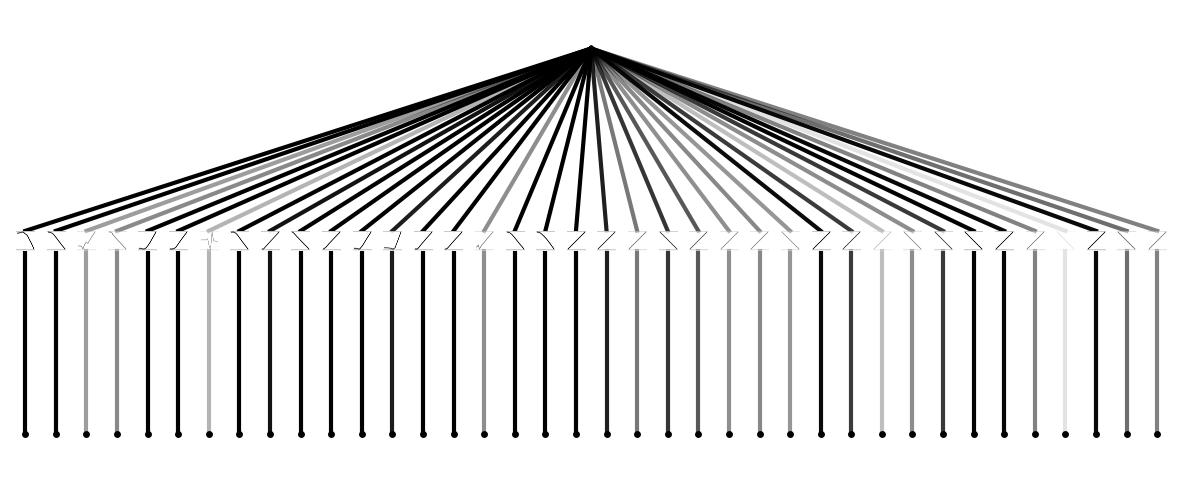

In [10]:
# plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100, scale=1.5)

Train KAN with sparsity regularization

In [11]:
# train the model
model.train()
lr = 0.01
model.fit(dataset, opt=optimizer, steps=20, lr=lr, lamb=0.01, lamb_entropy=10.)

train loss: 3.06e+01 | reg: 4.65e+01 : 100%|████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


{'train_loss': [array(29.97242209),
  array(29.2233307),
  array(29.78557737),
  array(29.37253355),
  array(29.53957268),
  array(29.15367428),
  array(29.34845371),
  array(30.29862782),
  array(28.19982963),
  array(28.63585987),
  array(30.26897407),
  array(29.65875167),
  array(29.62289634),
  array(29.1339714),
  array(30.04996473),
  array(29.52843963),
  array(29.44651939),
  array(29.75166439),
  array(28.77611213),
  array(30.62616998)],
 'test_loss': [],
 'reg': [array(46.73748549),
  array(46.95539805),
  array(47.82165446),
  array(46.7493483),
  array(47.21369662),
  array(48.51817927),
  array(48.51406111),
  array(48.47655141),
  array(47.94178031),
  array(48.13191607),
  array(48.06052385),
  array(47.4899307),
  array(47.51448656),
  array(47.48416209),
  array(48.08805767),
  array(47.52006034),
  array(47.4374176),
  array(47.51524802),
  array(46.44743305),
  array(46.54125659)]}

Plot trained KAN

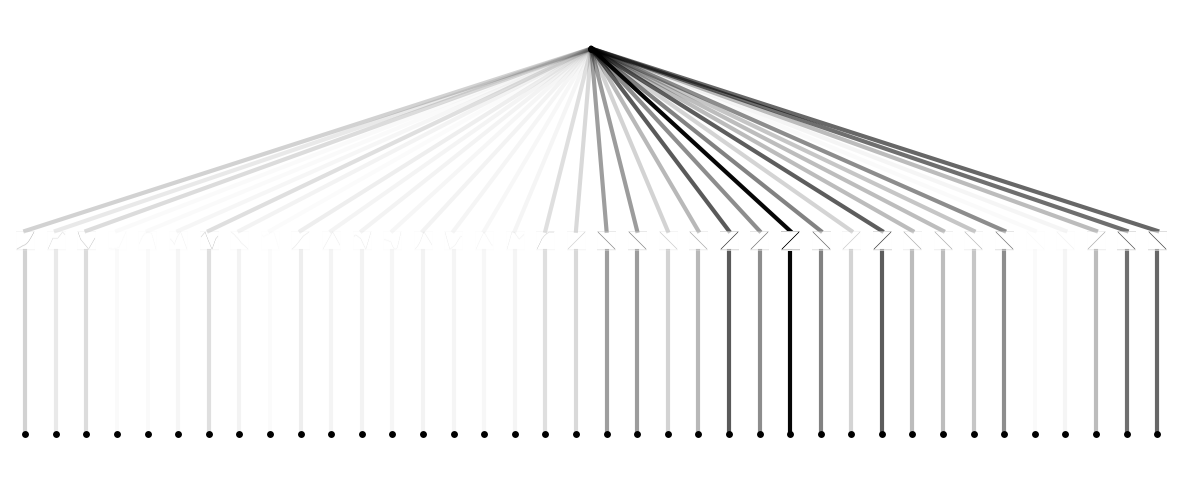

In [12]:
model.plot(scale=1.5)

In [13]:
model(dataset['test_input']).detach().cpu().numpy().flatten()

array([-0.88469855, -0.92779697, -0.48128607, ..., -1.04428442,
       -0.57642022, -0.82166643])

In [14]:
concordance_index_censored(
    dataset['test_event'] != 0, 
    dataset['test_time'], 
    model(dataset['test_input']).detach().cpu().numpy().flatten())[0]

0.6597098981696735

Prune KAN and replot (keep the original shape)

In [15]:
# model.prune()
# model.plot(mask=True, scale=1.5)

Prune KAN and replot (get a smaller shape)

In [16]:
# model = model.prune()
# model(dataset['train_input'])
# model.plot(scale=1.5)

Continue training and replot

In [17]:
# model.fit(dataset, opt=optimizer, lr=lr, steps=50)

In [18]:
# model.plot(scale=1.5)

In [19]:
# concordance_index_censored(
#     dataset['test_event'] != 0, 
#     dataset['test_time'], 
#     model(dataset['test_input']).detach().cpu().numpy().flatten())[0]

Automatically or manually set activation functions to be symbolic

In [20]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    # lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with tanh, r2=0.9967500511976254
fixing (0,1,0) with tanh, r2=0.93848173064755
fixing (0,2,0) with x^2, r2=0.9060507688742204
fixing (0,3,0) with tanh, r2=0.959661185239406
fixing (0,4,0) with x^2, r2=0.9545916555683354
fixing (0,5,0) with tanh, r2=0.638737659134378
fixing (0,6,0) with x^2, r2=0.8196540889086743
fixing (0,7,0) with tanh, r2=0.9978248827252093
fixing (0,8,0) with tanh, r2=0.8591177551427192
fixing (0,9,0) with tanh, r2=0.9997755808777572
fixing (0,10,0) with x^2, r2=0.9501634678441523
fixing (0,11,0) with tanh, r2=0.9378325142780461
fixing (0,12,0) with tanh, r2=0.5288961014837124
fixing (0,13,0) with tanh, r2=0.9072646925060198
fixing (0,14,0) with tanh, r2=0.9595258123451774
fixing (0,15,0) with x^2, r2=0.8526146698617553
fixing (0,16,0) with tanh, r2=0.9545376665638184
fixing (0,17,0) with tanh, r2=0.9995204799562325
fixing (0,18,0) with exp, r2=1.0000000000000016
fixing (0,19,0) with exp, r2=1.000000000000002
fixing (0,20,0) with x^4, r2=1.00000000000

Continue training to almost machine precision

In [21]:
model.fit(dataset, opt=optimizer, lr=lr, steps=20)

train loss: 2.89e+01 | reg: 1.20e+01 : 100%|████████████████████████| 20/20 [00:01<00:00, 10.78it/s]


{'train_loss': [array(29.07376508),
  array(29.12247501),
  array(28.72467329),
  array(29.38151978),
  array(29.57113274),
  array(29.73713099),
  array(29.5854262),
  array(29.43318488),
  array(30.10162521),
  array(29.52388502),
  array(30.04189412),
  array(29.814076),
  array(29.79311701),
  array(29.84408321),
  array(29.22773425),
  array(29.54683402),
  array(28.99118458),
  array(29.90219274),
  array(30.40039767),
  array(28.92153404)],
 'test_loss': [],
 'reg': [array(12.0251287),
  array(12.02765229),
  array(12.01733829),
  array(11.97606851),
  array(11.98200261),
  array(12.05608781),
  array(12.055432),
  array(12.05912233),
  array(12.05055895),
  array(12.01333413),
  array(11.9710829),
  array(11.96730061),
  array(11.9575254),
  array(11.97853907),
  array(11.9120661),
  array(12.05644402),
  array(12.07173819),
  array(12.06219753),
  array(12.05398144),
  array(12.04560382)]}

Obtain the symbolic formula

In [22]:
model.symbolic_formula()[0][0]

-0.05*(0.22 - x_5)**2 + 0.09*(0.64 - x_3)**2 + 0.06*(0.91 - x_7)**2 - 0.33*(1 - 0.31*x_11)**2 - 0.02*(1 - 0.73*x_16)**2 - 0.05*(-x_21 - 0.4)**4 + 0.16*(-x_24 - 0.39)**4 + 0.03*(-x_25 - 0.75)**4 - 0.04*(-x_27 - 0.59)**4 + 0.01*(-x_28 - 0.89)**4 + 0.02*(-x_36 - 0.67)**4 + 0.02*exp(1.73*x_19) + 0.01*exp(5.2*x_26) - 0.23*exp(0.81*x_38) + 2.31*tanh(0.35*x_1 - 1.0) + 0.45*tanh(0.34*x_10 - 0.61) - 0.2*tanh(1.03*x_12 - 0.36) + 0.22*tanh(1.31*x_13 - 3.15) + 0.1*tanh(1.24*x_14 - 0.23) - 0.27*tanh(1.12*x_15 + 0.66) + 0.26*tanh(2.01*x_17 + 0.41) + 0.41*tanh(0.79*x_18 + 0.25) + 0.24*tanh(1.63*x_2 + 1.05) + 0.81*tanh(0.73*x_4 - 2.8) + 0.02*tanh(2.75*x_6 - 1.06) - 0.75*tanh(0.19*x_8 - 0.3) - 0.25*tanh(0.96*x_9 - 2.38) + 2.51 - 0.51*exp(-3.19*x_29)

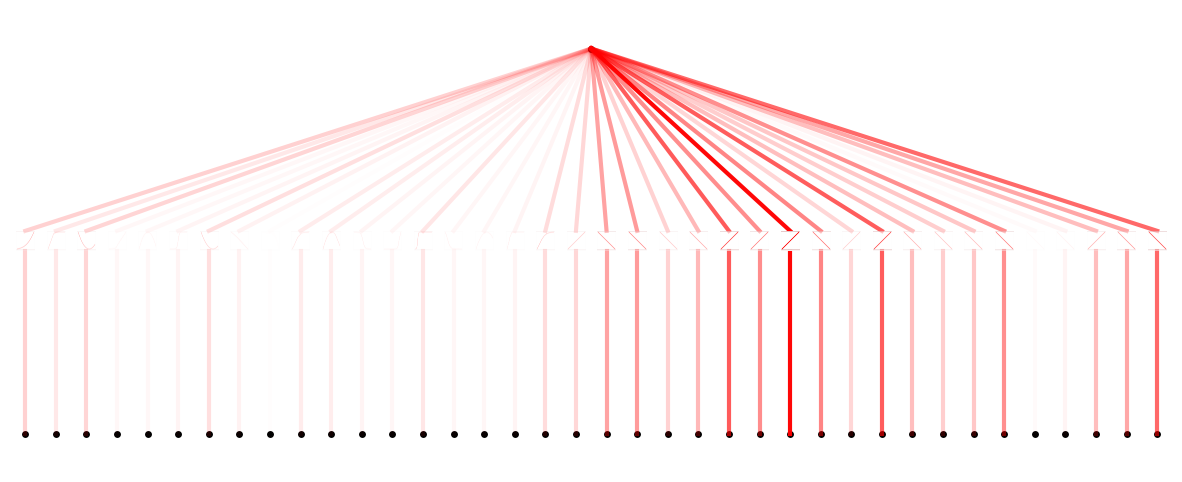

In [23]:
model.plot(scale=1.5)

In [24]:
model(dataset['test_input']).detach().cpu().numpy().flatten()

array([-1.04272086, -0.77895319, -0.17923876, ..., -0.7283405 ,
       -0.51984305, -0.71013463])

In [25]:
concordance_index_censored(
    dataset['test_event'] != 0, 
    dataset['test_time'], 
    model(dataset['test_input']).detach().cpu().numpy().flatten())[0]

0.6588163816217908

In [26]:
# out_risk = model.predict_risk(dataset, times)
# out_survival = model.predict_survival(dataset, times)
# # out_risk = model(dataset['test_input']).detach().cpu().numpy()
# # out_survival = - model(dataset['test_input']).detach().cpu().numpy()

In [27]:
# BreslowEstimator().fit(
#     model(dataset['train_input']).detach().cpu().numpy(), 
#     dataset['train_event'].numpy(), 
#     dataset['train_time'].numpy())

In [28]:
# BreslowEstimator()

In [29]:
# out_survival

In [30]:
# from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
# 
# cis, brs = [], []
# 
# et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))], dtype = [('e', bool), ('t', float)])
# et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))], dtype = [('e', bool), ('t', float)])
# et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))], dtype = [('e', bool), ('t', float)])
# 
# for i, _ in enumerate(times):
#     cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
#     
# brs.append(brier_score(et_train, et_test, out_survival, times)[1])
# 
# roc_auc = []
# for i, _ in enumerate(times):
#     roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
#     
# for horizon in enumerate(horizons):
#     print(f"For {horizon[1]} quantile,")
#     print("TD Concordance Index:", cis[horizon[0]])
#     print("Brier Score:", brs[0][horizon[0]])
#     print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

In [31]:
# from sksurv.linear_model.coxph import BreslowEstimator
# 
# 
# def fit_breslow(model, data):
#     return BreslowEstimator().fit(model(data['train_input']).detach().cpu().numpy(), data['train_event'].numpy(), data['train_time'].numpy())
# 
# breslow_spline = fit_breslow(model, dataset)

In [32]:
# unique_times = breslow_spline.baseline_survival_.x
# unique_times

In [33]:
# breslow_spline.get_survival_function(model(dataset['train_input']).detach().cpu().numpy())

In [34]:
# import pandas as pd
# 
# raw_predictions = breslow_spline.get_survival_function(model(dataset['train_input']).detach().cpu().numpy())
# raw_predictions = np.array([pred.y for pred in raw_predictions])
# 
# predictions = pd.DataFrame(data=raw_predictions, columns=unique_times)